In [ ]:
# chargement des bibliothèques
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# Chargement et exploration des données
data_dir = "drive/MyDrive/UTKFace/UTKFace"
file_paths = []
ages = []

for file in os.listdir(data_dir):
    if file.endswith(".jpg"):
        age = int(file.split("_")[0])
        file_paths.append(os.path.join(data_dir, file))
        ages.append(age)

In [ ]:
# Création d'un DataFrame

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df = pd.DataFrame({"file_path": file_paths, "age": ages})
df.head()

,file_path,age
0,drive/MyDrive/UTKFace/UTKFace/4_1_2_20161219141837833.jpg.chip.jpg,4
1,drive/MyDrive/UTKFace/UTKFace/4_1_1_20170109194638149.jpg.chip.jpg,4
2,drive/MyDrive/UTKFace/UTKFace/4_1_1_20170110213220193.jpg.chip.jpg,4
3,drive/MyDrive/UTKFace/UTKFace/4_1_1_20170112210910341.jpg.chip.jpg,4
4,drive/MyDrive/UTKFace/UTKFace/4_1_1_20161219160210758.jpg.chip.jpg,4


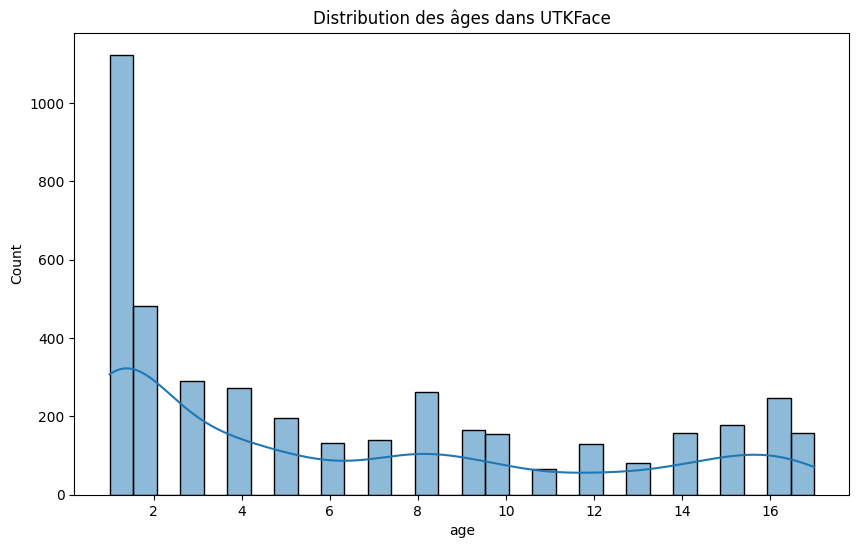

In [ ]:
# Visualisation de la distribution des âges
plt.figure(figsize=(10, 6))
sns.histplot(df["age"], bins=30, kde=True)
plt.title("Distribution des âges dans UTKFace")
plt.show()

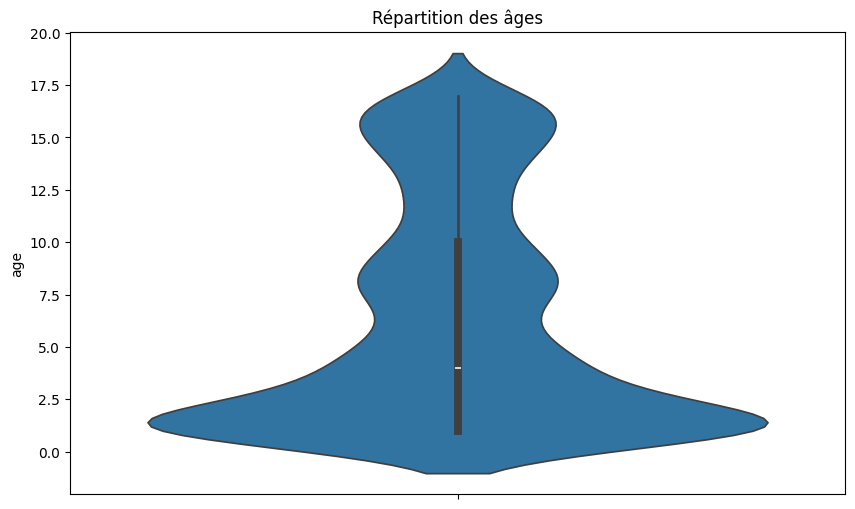

In [ ]:
# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(y=df["age"])
plt.title("Répartition des âges")
plt.show()

In [ ]:
# Préparation des données
img_height, img_width = 200, 200
batch_size = 32

In [ ]:
def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0
    return img, label

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["file_path"], df["age"], test_size=0.2, random_state=42)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(process_image).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(process_image).batch(batch_size)

In [ ]:
# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [ ]:
# Modèle CNN pour la régression (prédiction d'âge)
model_regression = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model_regression.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Entraînement
history_reg = model_regression.fit(train_data, validation_data=test_data, epochs=15)

Epoch 1/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - loss: 55.2647 - mae: 6.0426 - val_loss: 81.5841 - val_mae: 7.5104
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 30s 126ms/step - loss: 28.3413 - mae: 4.2965 - val_loss: 26.8789 - val_mae: 3.6685
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - loss: 13.2653 - mae: 2.7482 - val_loss: 19.3028 - val_mae: 3.1267
Epoch 4/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 10.9744 - mae: 2.5535 - val_loss: 13.5995 - val_mae: 3.1233
Epoch 5/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 9.6793 - mae: 2.4105 - val_loss: 11.3675 - val_mae: 2.6937
Epoch 6/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 9.2558 - mae: 2.3439 - val_loss: 14.5221 - val_mae: 3.0414
Epoch 7/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - loss: 8.9709 - mae: 2.2736 - val_loss: 13.7198 - val_mae: 2.8970
Epoch 8/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - loss: 8.5061 - mae: 2.2262 - val_loss: 13.0572 - val_mae: 2.8436
Epoch 9/15
106/106 ━━━

In [ ]:
# Modèle CNN pour la classification par classes d'âge
bins = [0, 3, 7, 10, 15, 20]  # Par exemple, des tranches de 0-3, 4-7, etc.
labels = [0, 1, 2, 3, 4]  # 0: 0-3 ans, 1: 4-7 ans, 2: 8-10 ans, etc.
df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels)

#bins = [0, 18, 30, 45, 60, 100]
#labels = [0, 1, 2, 3, 4]
#df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels)

#bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
#names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["file_path"], df["age_group"].astype(int), test_size=0.2, random_state=42)
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(process_image).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(process_image).batch(batch_size)


In [ ]:
model_classification = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(labels), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model_classification.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Entraînement
history_class = model_classification.fit(train_data, validation_data=test_data, epochs=15)

Epoch 1/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.4385 - loss: 1.7548 - val_accuracy: 0.4250 - val_loss: 1.5101
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.5621 - loss: 1.0840 - val_accuracy: 0.4215 - val_loss: 1.6235
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.5822 - loss: 1.0019 - val_accuracy: 0.4298 - val_loss: 1.7912
Epoch 4/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.6075 - loss: 0.9451 - val_accuracy: 0.4935 - val_loss: 1.2530
Epoch 5/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.6314 - loss: 0.8974 - val_accuracy: 0.5242 - val_loss: 1.1322
Epoch 6/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.6397 - loss: 0.8672 - val_accuracy: 0.4699 - val_loss: 1.2881
Epoch 7/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.6658 - loss: 0.8253 - val_accuracy: 0.5407 - val_loss: 1.1515
Epoch 8/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.6696 - loss: 0

In [ ]:
# Évaluation
y_pred_reg = model_regression.predict(test_data).flatten()
y_pred_class = np.argmax(model_classification.predict(test_data), axis=1)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step


In [ ]:
mae = np.mean(np.abs(y_pred_reg - y_test))
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')
cm = confusion_matrix(y_test, y_pred_class)

In [ ]:
# Affichage des résultats
print(f"MAE (Régression) : {mae}")
print(f"Accuracy (Classification) : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1-score : {f1}")
print("Matrice de confusion :\n", cm)

MAE (Régression) : 6.915277492866324
Accuracy (Classification) : 0.6139315230224321
Precision : 0.5925417613096606
Recall : 0.6139315230224321
F1-score : 0.5971597128728586
Matrice de confusion :
 [[331  21   1   2   2]
 [ 54  83  22  10   9]
 [ 12  26  38  17  14]
 [  8  20  37  31  31]
 [  8   4  14  15  37]]


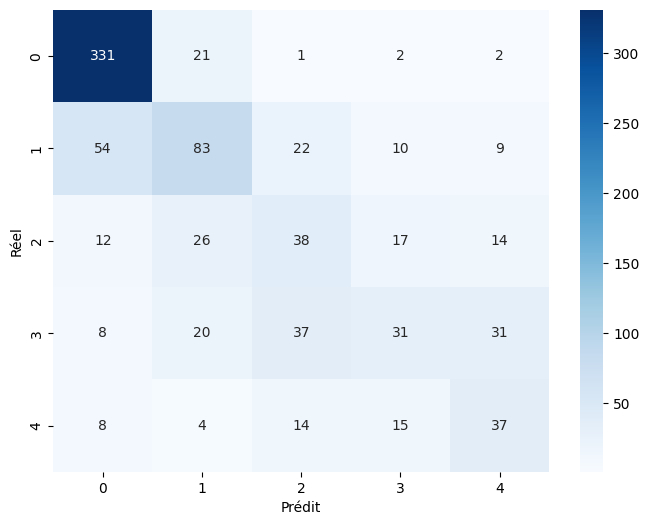

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

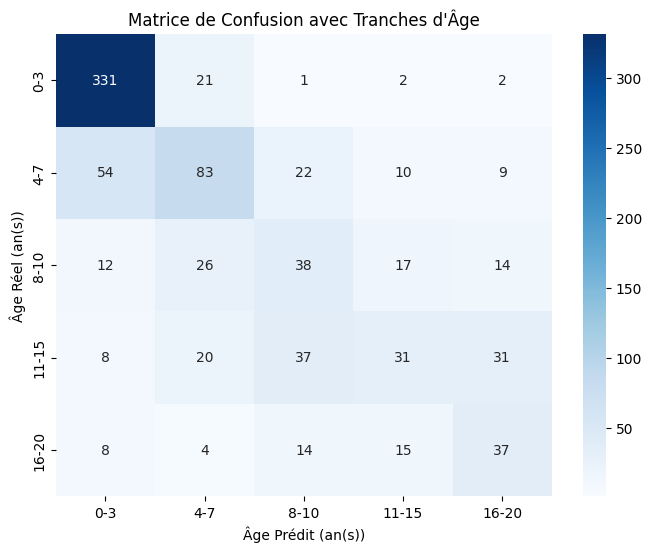

In [ ]:
# Affichage de la heatmap avec les bonnes étiquettes pour les classes
plt.figure(figsize=(8, 6))

# Remplacer les étiquettes par les tranches d'âge dans la matrice de confusion
age_groups = ['0-3', '4-7', '8-10', '11-15', '16-20']  # Correspond aux labels des bins

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=age_groups, yticklabels=age_groups)

plt.xlabel("Âge Prédit (an(s))")
plt.ylabel("Âge Réel (an(s))")
plt.title("Matrice de Confusion avec Tranches d'Âge")
plt.show()

In [ ]:
# Récupérer les valeurs de loss et MAE depuis l'entraînement
loss = history_reg.history['loss']
val_loss = history_reg.history['val_loss']
mae = history_reg.history['mae']
val_mae = history_reg.history['val_mae']

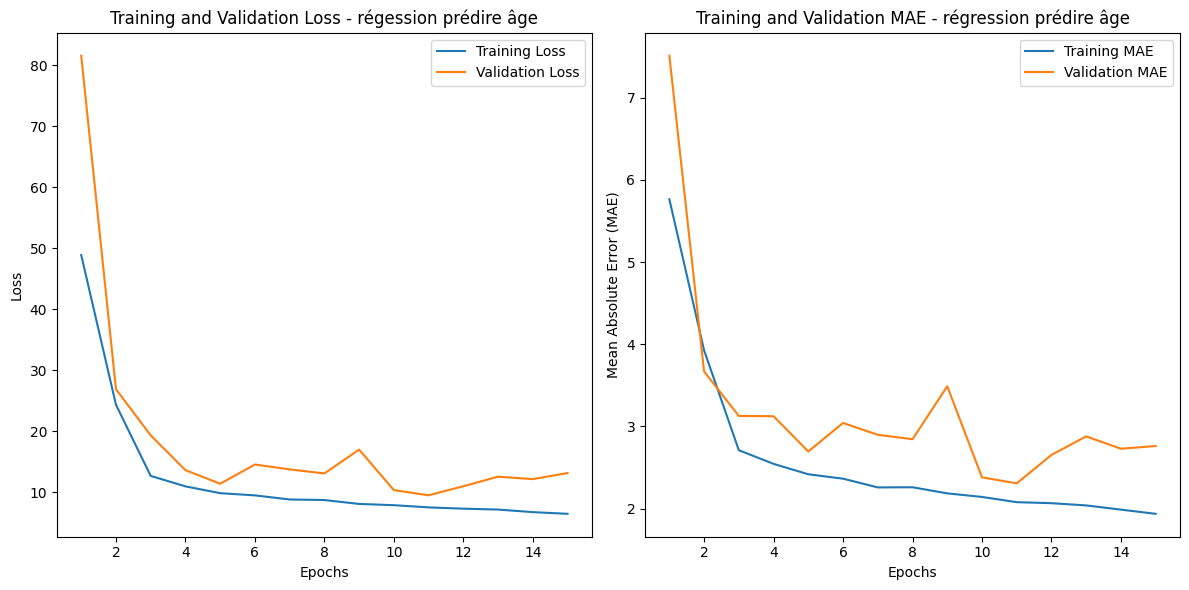

In [ ]:
# Tracer les courbes de loss et MAE
plt.figure(figsize=(12, 6))

# Courbes de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 16), loss, label="Training Loss")
plt.plot(range(1, 16), val_loss, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - régession prédire âge')
plt.legend()

# Courbes de MAE (Mean Absolute Error)
plt.subplot(1, 2, 2)
plt.plot(range(1, 16), mae, label="Training MAE")
plt.plot(range(1, 16), val_mae, label="Validation MAE")
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE - régression prédire âge')
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()

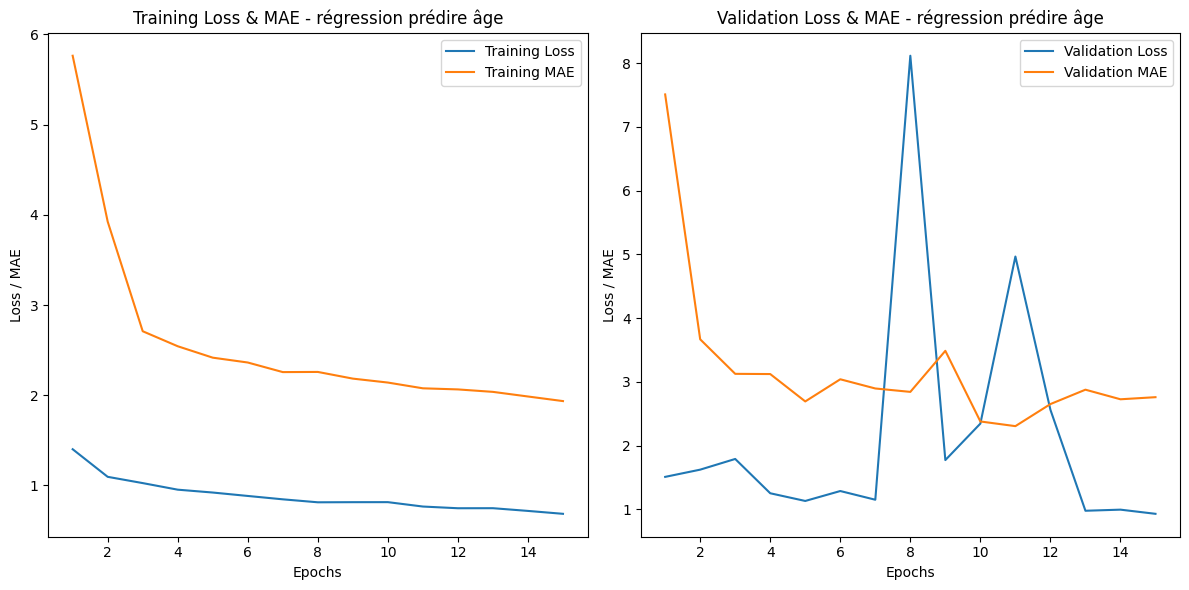

In [ ]:
# Tracer les courbes de loss et MAE pour l'entraînement et la validation
plt.figure(figsize=(12, 6))

# Loss et MAE pour l'entraînement
plt.subplot(1, 2, 1)
# Courbe de Loss pour l'entraînement
plt.plot(range(1, 16), loss, label="Training Loss")
# Courbe de MAE pour l'entraînement
plt.plot(range(1, 16), mae, label="Training MAE")
plt.xlabel('Epochs')
plt.ylabel('Loss / MAE')
plt.title('Training Loss & MAE - régression prédire âge')
plt.legend()

# Loss et MAE pour la validation
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, deuxième vignette
# Courbe de Loss pour la validation
plt.plot(range(1, 16), val_loss, label="Validation Loss")
# Courbe de MAE pour la validation
plt.plot(range(1, 16), val_mae, label="Validation MAE")
plt.xlabel('Epochs')
plt.ylabel('Loss / MAE')
plt.title('Validation Loss & MAE - régression prédire âge')
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()


In [ ]:
# Récupération des données d'accuracy et de loss (classification multi-classes)
acc = history_class.history['accuracy']
val_acc = history_class.history['val_accuracy']
loss = history_class.history['loss']
val_loss = history_class.history['val_loss']


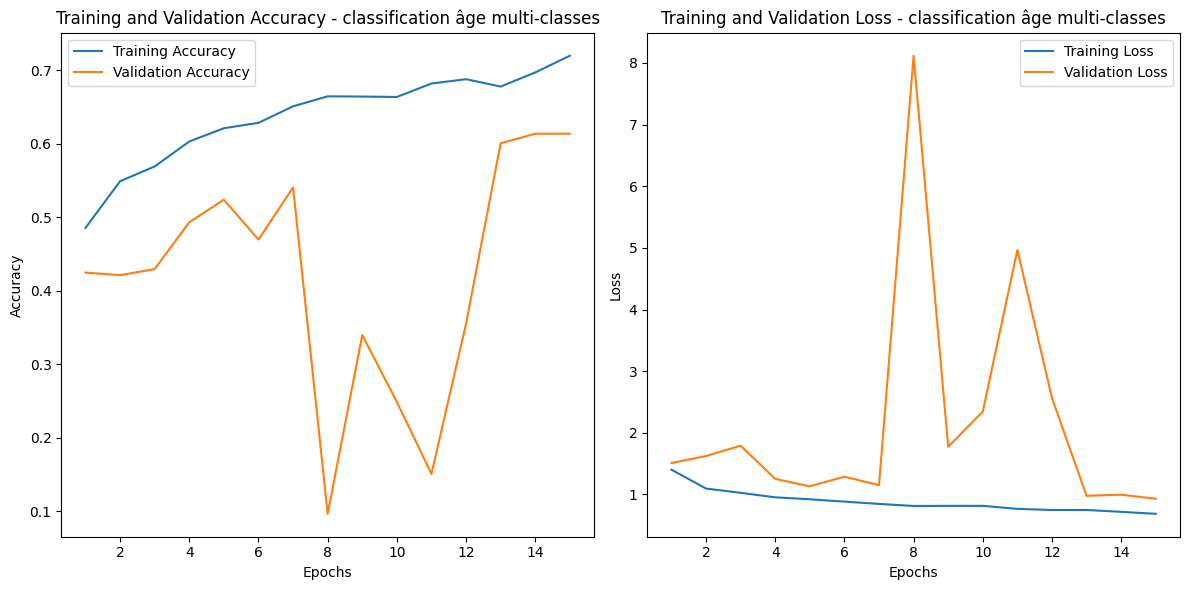

In [ ]:
# Tracer les courbes de comparaison de l'accuracy et de loss entre training et validation (test)
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, 16), acc, label="Training Accuracy")
plt.plot(range(1, 16), val_acc, label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - classification âge multi-classes')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, 16), loss, label="Training Loss")
plt.plot(range(1, 16), val_loss, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - classification âge multi-classes')
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()

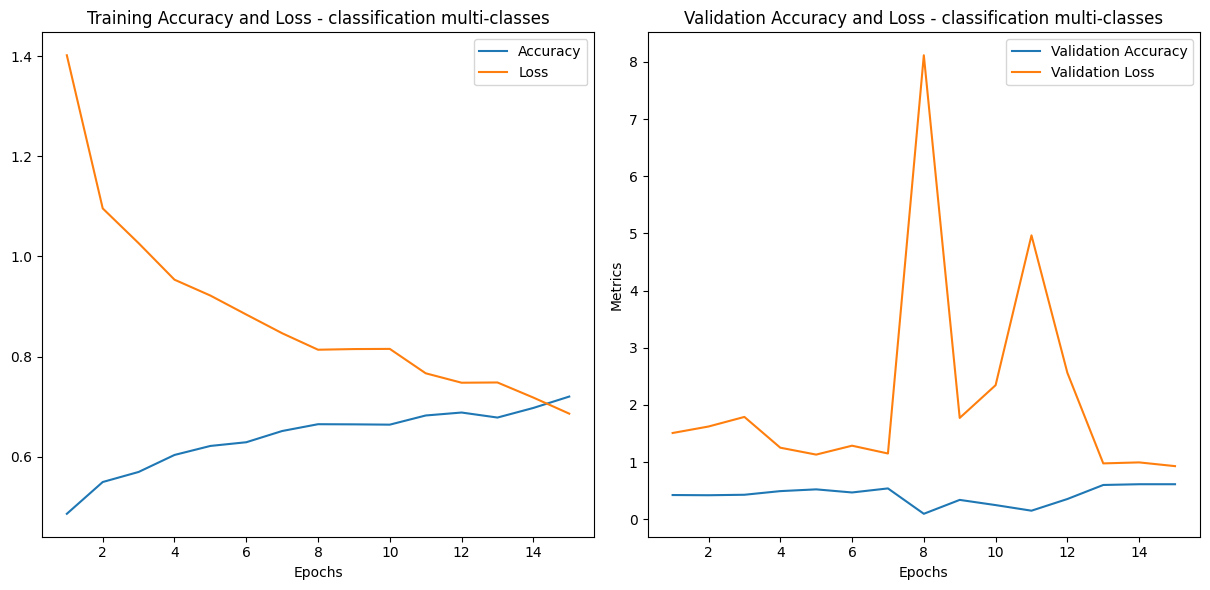

In [ ]:
# Tracer pour chacun des ensembles d'entraînement et de test les courbes de l'accuracy et de loss
plt.figure(figsize=(24, 6))  # Augmenter la largeur pour accueillir 4 subplots

# Training Accuracy and Loss
plt.subplot(1, 4, 3)  # 1 ligne, 4 colonnes, 3e subplot
plt.plot(range(1, 16), acc, label="Accuracy")
plt.plot(range(1, 16), loss, label="Loss")
plt.xlabel('Epochs')
plt.title('Training Accuracy and Loss - classification âge multi-classes')
plt.legend()

# Validation Accuracy and Loss
plt.subplot(1, 4, 4)  # 1 ligne, 4 colonnes, 4e subplot
plt.plot(range(1, 16), val_acc, label="Validation Accuracy")
plt.plot(range(1, 16), val_loss, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Validation Accuracy and Loss - classification âge multi-classes')
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


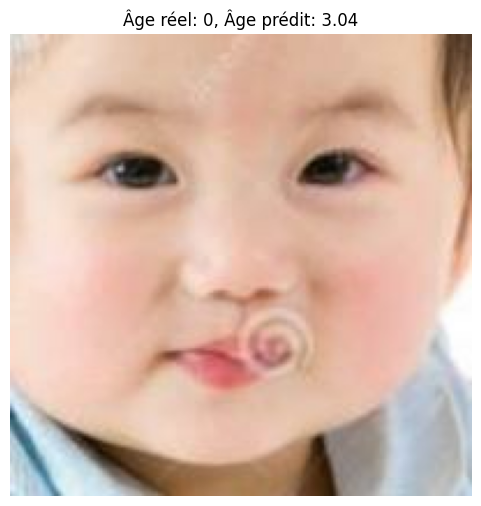

In [ ]:
import random

# Sélectionner une image au hasard à partir de l'ensemble de test
random_index = random.randint(0, len(X_test) - 1)
file_path = X_test.iloc[random_index]
real_age = y_test.iloc[random_index]

# Charger et prétraiter l'image
image, _ = process_image(file_path, real_age)

# Affichage de l'image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')

# Prédire l'âge de l'image avec le modèle de régression
predicted_age = model_regression.predict(tf.expand_dims(image, axis=0)).flatten()[0]

# Afficher l'âge réel et prédit sur l'image
plt.title(f"Âge réel: {real_age}, Âge prédit: {predicted_age:.2f}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


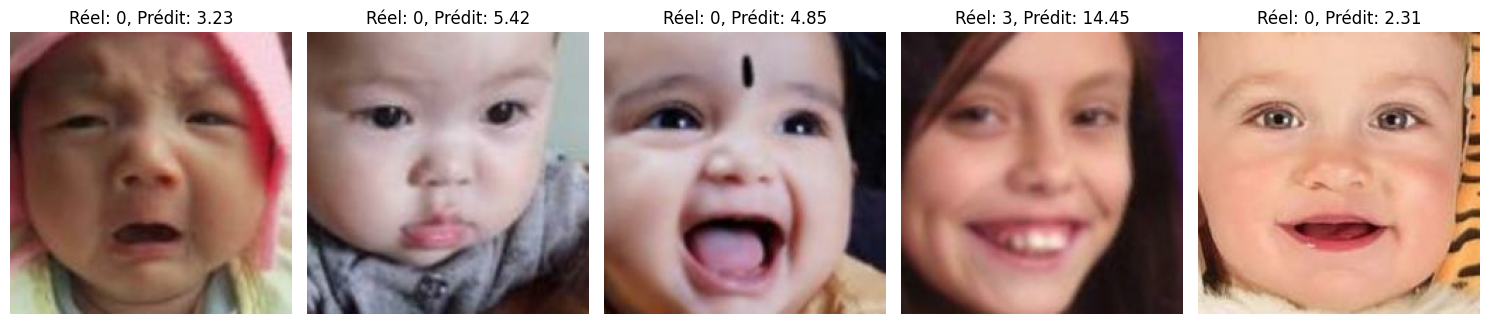

In [ ]:
# Nombre d'images à afficher
num_images = 5

# Créer une figure pour afficher les images
plt.figure(figsize=(15, 15))

# Sélectionner et afficher plusieurs images aléatoires
for i in range(num_images):
    random_index = random.randint(0, len(X_test) - 1)
    file_path = X_test.iloc[random_index]
    real_age = y_test.iloc[random_index]

    # Charger et prétraiter l'image
    image, _ = process_image(file_path, real_age)

    # Prédire l'âge de l'image avec le modèle de régression
    predicted_age = model_regression.predict(tf.expand_dims(image, axis=0)).flatten()[0]

    # Afficher l'image dans un sous-graphe (médaillon)
    plt.subplot(1, num_images, i + 1)  # 1 ligne et 'num_images' colonnes
    plt.imshow(image)
    plt.axis('off')

    # Afficher l'âge réel et prédit sur l'image
    plt.title(f"Réel: {real_age}, Prédit: {predicted_age:.2f}")

# Affichage de toutes les images
plt.tight_layout()
plt.show()